# Sentiment Analysis in Python

This notebook is part of a tutorial that can be found on my [youtube channel here](https://www.youtube.com/channel/UCxladMszXan-jfgzyeIMyvw), please check it out!

In this notebook we will be doing some sentiment analysis in python using two different techniques:
1. VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
2. Roberta Pretrained Model from 🤗
3. Huggingface Pipeline

# Step 0. Read in Data and NLTK Basics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Premalatha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# Read in data
df = pd.read_csv('Reviews.csv')
print(df.shape)
df = df.head(500)
print(df.shape)

(568454, 10)
(500, 10)


In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Quick EDA

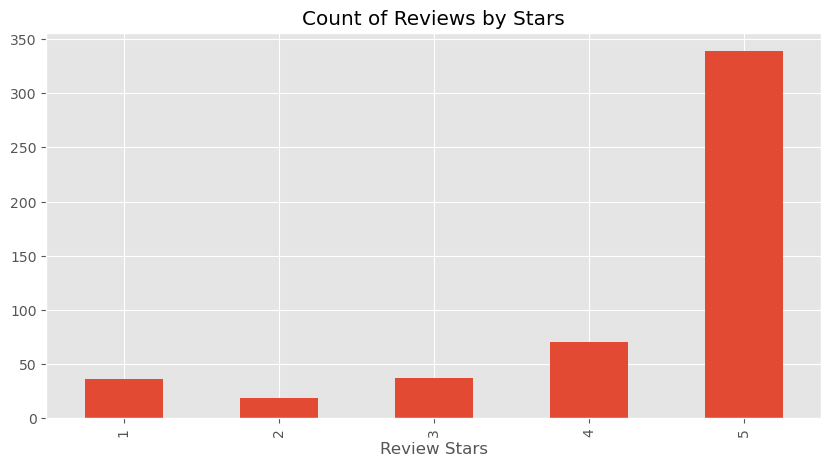

In [4]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## Basic NLTK

In [5]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [6]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [7]:
nltk.download('averaged_perceptron_tagger')
tagged = nltk.pos_tag(tokens)
tagged[:10]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Premalatha\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [8]:
nltk.download('maxent_ne_chunker')
nltk.download('words')
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Premalatha\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Premalatha\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


# Step 1. VADER Sentiment Scoring

We will use NLTK's `SentimentIntensityAnalyzer` to get the neg/neu/pos scores of the text.

- This uses a "bag of words" approach:
    1. Stop words are removed
    2. each word is scored and combined to a total score.

In [9]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Premalatha\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [10]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [11]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [12]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [13]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [14]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [15]:
# Now we have sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Plot VADER results

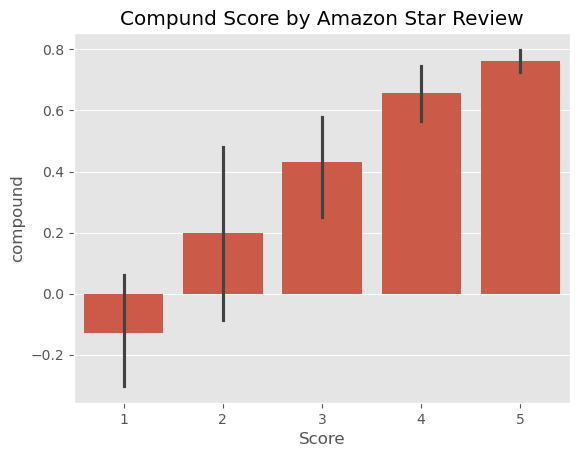

In [16]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

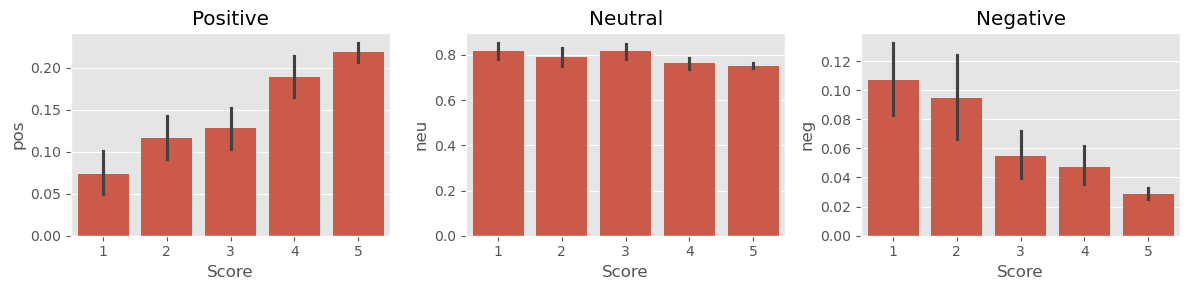

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Step 3. Roberta Pretrained Model

- Use a model trained of a large corpus of data.
- Transformer model accounts for the words but also the context related to other words.

In [20]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [21]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [22]:
# VADER results on example
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [23]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687453, 'roberta_pos': 0.0029573678}


In [24]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [25]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [26]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

## Compare Scores between models

In [27]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

# Step 3. Combine and compare

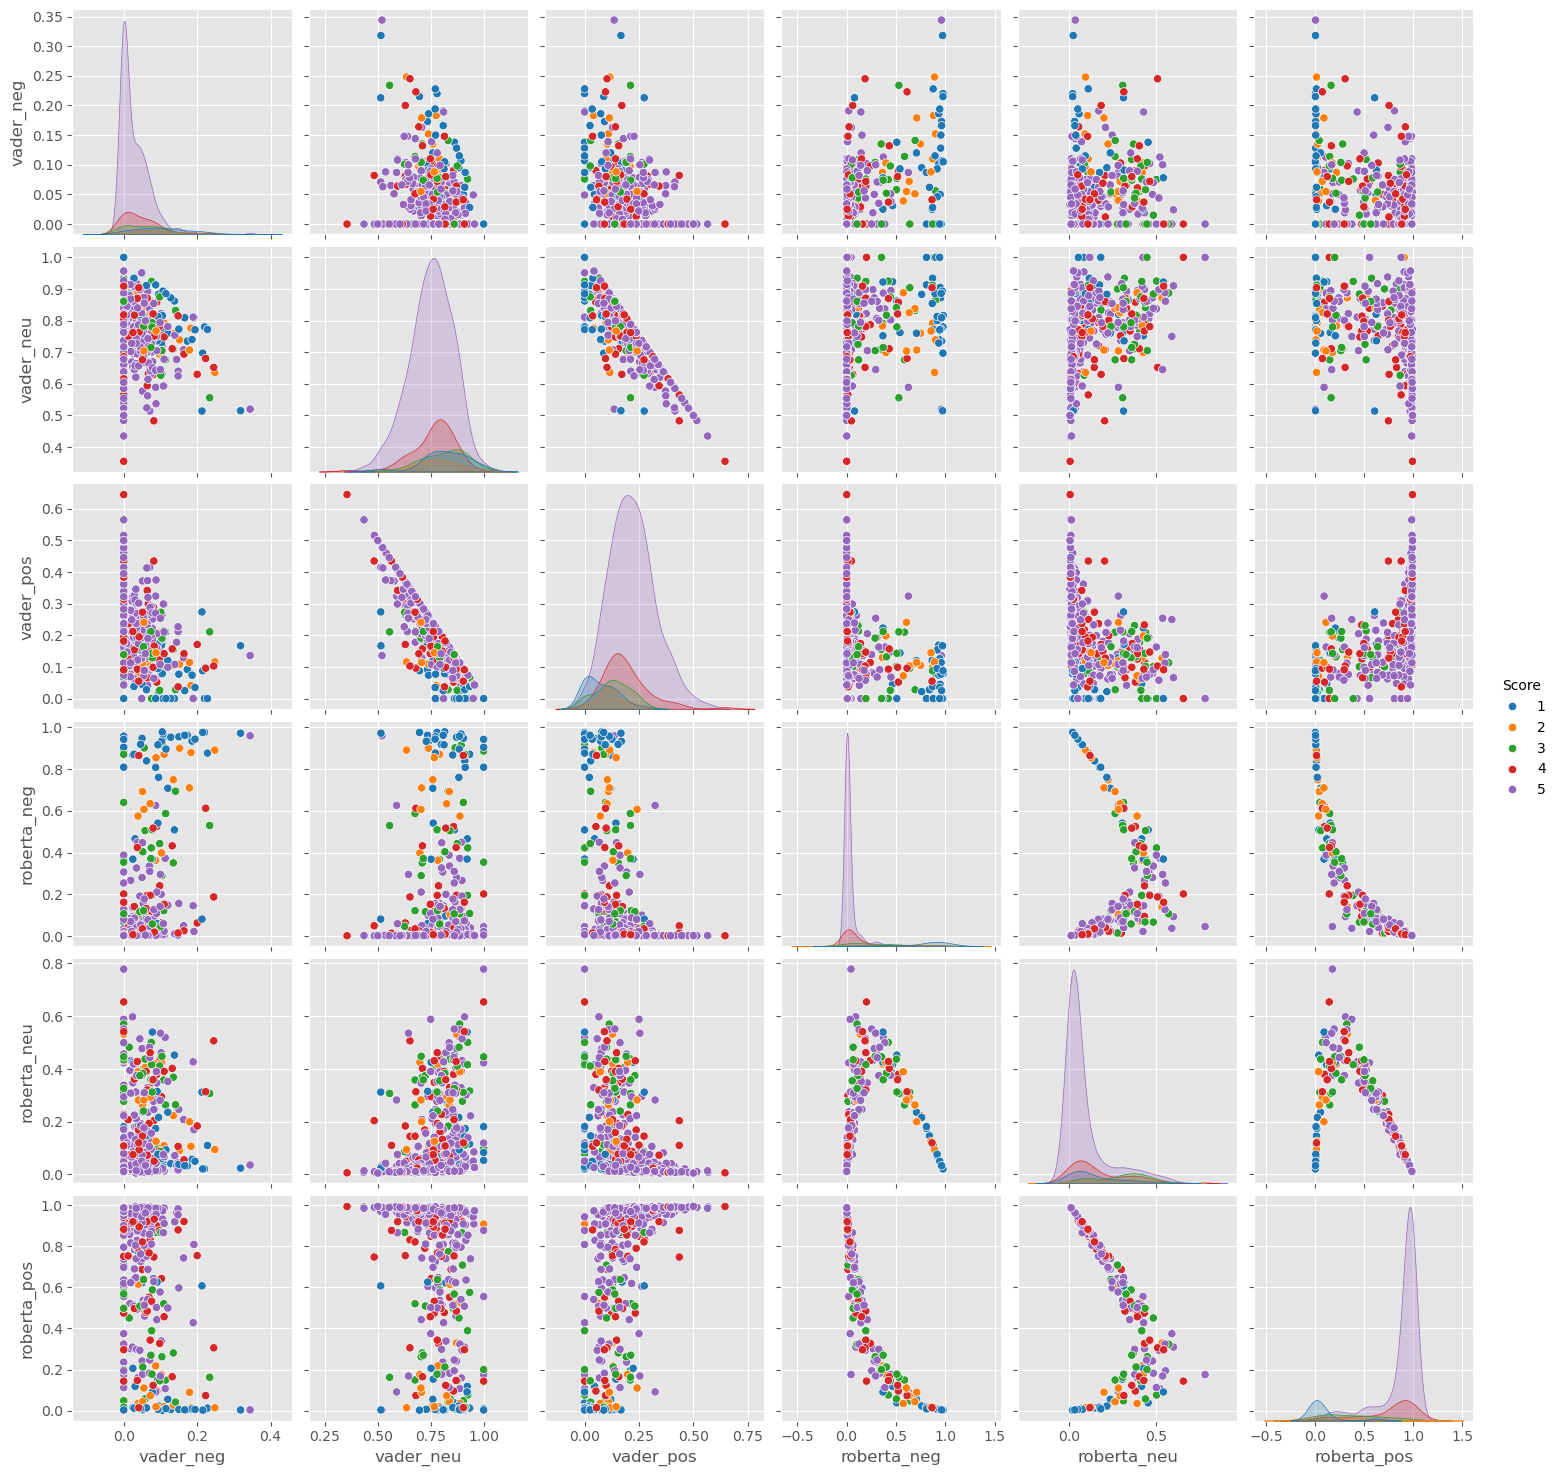

In [28]:
sns.pairplot(data=results_df, vars=['vader_neg', 'vader_neu', 'vader_pos','roberta_neg', 'roberta_neu', 'roberta_pos'],hue='Score',palette='tab10')
plt.show()

# Step 4: Review Examples:

- Positive 1-Star and Negative 5-Star Reviews

Lets look at some examples where the model scoring and review score differ the most.

In [29]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [30]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [31]:
# nevative sentiment 5-Star view

In [32]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [33]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

# Extra: The Transformers Pipeline
- Quick & easy way to run sentiment predictions

In [37]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [38]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [39]:
sent_pipeline('Make sure to like and subscribe!')

[{'label': 'POSITIVE', 'score': 0.9991742968559265}]

In [40]:
sent_pipeline('Despite my best efforts, the computer crashed just as I was about to save the important document, leaving me utterly frustrated.')

[{'label': 'NEGATIVE', 'score': 0.9997091889381409}]

In [41]:
sent_pipeline('The first rays of dawn illuminate the horizon, inspiring a renewed sense of hope for a brighter and better tomorrow.')

[{'label': 'POSITIVE', 'score': 0.9998134970664978}]

In [42]:
sent_pipeline('I got 97 marks in Physics out of 100')

[{'label': 'POSITIVE', 'score': 0.9936608076095581}]

In [43]:
sent_pipeline('I got poor marks in Physics out of 100')

[{'label': 'NEGATIVE', 'score': 0.9997472167015076}]

In [44]:
sent_pipeline('I beat my friend in Physics out of 100')

[{'label': 'NEGATIVE', 'score': 0.954475462436676}]

In [45]:
sent_pipeline('He has bad manners')

[{'label': 'NEGATIVE', 'score': 0.9926871061325073}]

In [46]:
sent_pipeline('He has good hospital behaviour')

[{'label': 'POSITIVE', 'score': 0.9934819340705872}]

In [47]:
sent_pipeline('The outcome fell short of my expectations, leaving a lingering sense of disappointment and a tinge of sadness.')

[{'label': 'NEGATIVE', 'score': 0.998279333114624}]

In [48]:
sent_pipeline('The playful antics of the mischievous puppy never fail to bring a smile to my face, turning a mundane day into a delightful one.')

[{'label': 'POSITIVE', 'score': 0.9998501539230347}]

In [49]:
sent_pipeline('My friend just gave me his phone number. I am so excited.')

[{'label': 'POSITIVE', 'score': 0.9996899366378784}]

In [50]:
sent_pipeline('My mother slapped me for wasting food.')

[{'label': 'NEGATIVE', 'score': 0.9995867609977722}]

In [51]:
sent_pipeline('Akishita is a coward as she is unable to face her fears')

[{'label': 'NEGATIVE', 'score': 0.9993242025375366}]

In [52]:
sent_pipeline('Akshay is hardworking. He made it to the top selling architect')

[{'label': 'POSITIVE', 'score': 0.9997689127922058}]

# Customer Feedback Sentiment Analysis

In [53]:
sent_pipeline("Terrible! Artificial lemon taste, like Pledge Lemon Furniture Polish. Don't do this to yourself. Just use plain flake salt and some fresh grated lemon zest.")

[{'label': 'NEGATIVE', 'score': 0.9950335025787354}]

In [54]:
sent_pipeline("Bought a set of two when my son was about 6 months, and we started taking them with us whenever we went out to eat.  I cut up cantaloupe, apple, banana (even used sweet potatoes a few times)-- just whatever I could get at the restaurant-- and it would keep my son busy long enough that I could actually eat!  It's great because I didn't have to be overly worried about him choking on big chunks, and he got to try out new foods.  I wouldn't hesitate to buy this again.")

[{'label': 'POSITIVE', 'score': 0.9996291399002075}]

In [55]:
sent_pipeline("Look elsewhere for your whole grains")

[{'label': 'NEGATIVE', 'score': 0.9997534155845642}]

In [56]:
sent_pipeline("These are Famous for a reason.")

[{'label': 'POSITIVE', 'score': 0.9992334842681885}]

In [57]:
sent_pipeline("Salty and vinegary!!!")

[{'label': 'NEGATIVE', 'score': 0.9699772000312805}]

In [58]:
sent_pipeline("Tangy goodness.")

[{'label': 'POSITIVE', 'score': 0.9998563528060913}]

In [59]:
sent_pipeline("Barbeque perfection")

[{'label': 'POSITIVE', 'score': 0.9998190999031067}]

In [60]:
sent_pipeline("70% of the chips in the bag are over cooked")

[{'label': 'NEGATIVE', 'score': 0.9988678693771362}]